## Mount Google Drive

In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [2]:
import os
os.chdir("drive/My Drive/BTP/NN")

In [3]:
!ls

Model1.ipynb  Model3.ipynb  Neuralnetwork.ipynb  SlidingWindows.py
Model2.ipynb  Network.py    __pycache__


## Import Modules and Data

In [4]:
import numpy as np
import pandas as pd
import copy as cp
import pandas as pd
import matplotlib.pyplot as plt
from SlidingWindows import *
from Network import *
import time
import seaborn as sns
sns.set()

In [5]:
data = pd.read_csv('../data/sales_train_validation.csv')
calender = pd.read_csv('../data/calendar.csv')

## Analysis for a category in one particular state

In [6]:
cat_id = "HOUSEHOLD"

states = ['CA', 'TX', 'WI']

state_id_1 = states[0]
category_state = data[(data['cat_id'] == cat_id) & (data['state_id'] == state_id_1)].to_numpy()[:,6:]
category_state.shape
y1 = np.sum(category_state, axis = 0)
# print(y1.shape)

state_id_2 = states[1]
category_state = data[(data['cat_id'] == cat_id) & (data['state_id'] == state_id_2)].to_numpy()[:,6:]
category_state.shape
y2 = np.sum(category_state, axis = 0)
# print(y2.shape)

state_id_3 = states[2]
category_state = data[(data['cat_id'] == cat_id) & (data['state_id'] == state_id_3)].to_numpy()[:,6:]
category_state.shape
y3 = np.sum(category_state, axis = 0)
# print(y3.shape)

In [7]:
def divide(a, b):
    return np.divide(a, b, out=np.zeros_like(a), where=b!=0)

CA
TX
WI


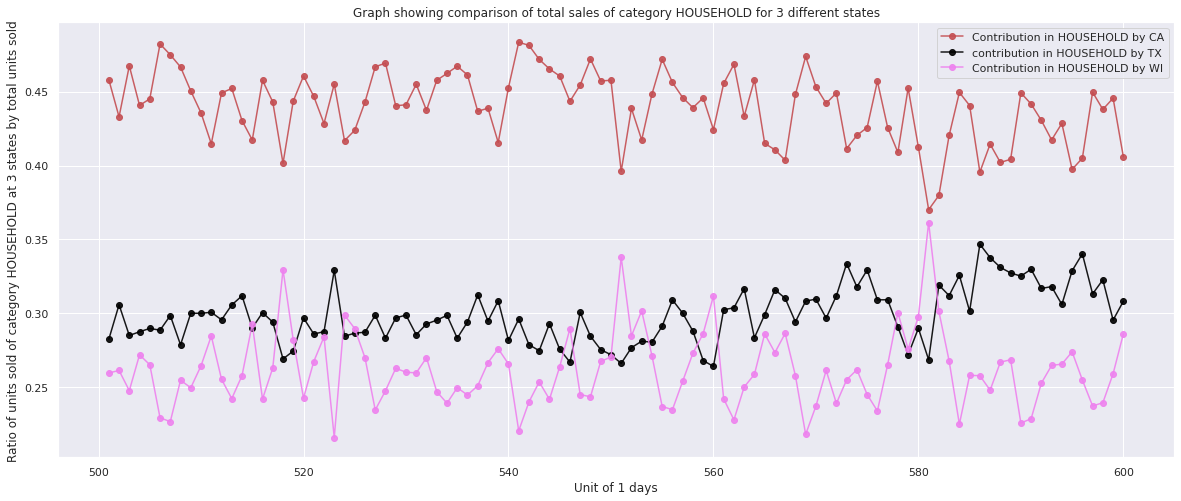

In [8]:
start = 400
end = 1913
MAX = 1913

distribution = {}

for s in zip(states, [y1, y2, y3]):
  print(s[0])
  mean_y = divide(s[1], (y1 + y2 + y3))[start:end].mean()
  distribution[s[0]] = [i if i > 0 and i < 1 else mean_y for i in divide(s[1], (y1 + y2 + y3))[start:end]]

t = np.array(range(1, MAX + 1))[start:end]

plt.figure(figsize=(20, 8))

graph_start = 100
graph_end = 200

plt.plot(t[graph_start: graph_end], distribution['CA'][graph_start: graph_end],label=f'Contribution in {cat_id} by {state_id_1}',marker='o', c="r", alpha=0.9)
plt.plot(t[graph_start: graph_end], distribution['TX'][graph_start: graph_end],label=f'contribution in {cat_id} by {state_id_2}',marker='o', c="black", alpha=0.9)
plt.plot(t[graph_start: graph_end], distribution['WI'][graph_start: graph_end],label=f'Contribution in {cat_id} by {state_id_3}',marker='o', c="violet", alpha=0.9)

plt.xlabel(f'Unit of 1 days')
plt.ylabel(f'Ratio of units sold of category {cat_id} at 3 states by total units sold')
plt.legend() 
plt.title(f'Graph showing comparison of total sales of category {cat_id} for 3 different states')
plt.show()

## Add events to training set

In [10]:
calender

,date,wm_yr_wk,weekday,wday,month,year,d,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI
0,2011-01-29,11101,Saturday,1,1,2011,d_1,NaN,NaN,NaN,NaN,0,0,0
1,2011-01-30,11101,Sunday,2,1,2011,d_2,NaN,NaN,NaN,NaN,0,0,0
2,2011-01-31,11101,Monday,3,1,2011,d_3,NaN,NaN,NaN,NaN,0,0,0
3,2011-02-01,11101,Tuesday,4,2,2011,d_4,NaN,NaN,NaN,NaN,1,1,0
4,2011-02-02,11101,Wednesday,5,2,2011,d_5,NaN,NaN,NaN,NaN,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1964,2016-06-15,11620,Wednesday,5,6,2016,d_1965,NaN,NaN,NaN,NaN,0,1,1
1965,2016-06-16,11620,Thursday,6,6,2016,d_1966,NaN,NaN,NaN,NaN,0,0,0
1966,2016-06-17,11620,Friday,7,6,2016,d_1967,NaN,NaN,NaN,NaN,0,0,0
1967,2016-06-18,11621,Saturday,1,6,2016,d_1968,NaN,NaN,NaN,NaN,0,0,0


In [11]:
calender.event_type_1.dropna().unique()

array(['Sporting', 'Cultural', 'National', 'Religious'], dtype=object)

In [12]:
for evnt in calender.event_type_1.dropna().unique():
  calender[f'{evnt.lower()}_1'] = [1 if type(i) == str and i == evnt else 0 for i in calender.event_type_1]

for evnt in calender.event_type_1.dropna().unique():
  calender[f'{evnt.lower()}_2'] = [1 if type(i) == str and i == evnt else 0 for i in calender.event_type_2]

calender_train_data = calender.iloc[:,11:][start:end].reset_index(drop=True)
calender_train_data

,snap_CA,snap_TX,snap_WI,sporting_1,cultural_1,national_1,religious_1,sporting_2,cultural_2,national_2,religious_2
0,1,0,0,0,0,0,0,0,0,0,0
1,1,1,1,0,0,0,0,0,0,0,0
2,1,1,1,0,0,0,0,0,0,0,0
3,1,1,0,0,0,0,0,0,0,0,0
4,1,0,1,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...
1508,0,0,0,0,0,0,0,0,0,0,0
1509,0,0,0,0,0,0,0,0,0,0,0
1510,0,0,0,0,0,0,0,0,0,0,0
1511,0,0,0,0,0,0,0,0,0,0,0


In [25]:
shift = 7 * 52
sz = end - start
period = 7
# t = np.arange(start, end, 1).reshape(-1,1)

previous_days_y = np.array([t])
columns = ['t']

k = 1
for state in states:
  for index, s in enumerate(range(7, shift + 1, period)):
    columns.append('x' + str(k) + str(s // period))
    x = np.array([distribution[state][i-s] if i - s >= 0 else 0 for i in range(0,sz)])
    previous_days_y = np.vstack([previous_days_y, x])
  k += 1

previous_days_y.shape

(157, 1513)

## Build dataset

In [26]:
concatenated_data_tuple = tuple(previous_days_y)

dataset = pd.DataFrame(np.transpose(previous_days_y), columns = columns)

dataset = pd.concat([dataset, calender_train_data], axis=1)

dataset = dataset.iloc[shift:,:].reset_index(drop=True)

for index, state in enumerate(states): 
  dataset['y' + str(index + 1)] = distribution[state][shift:]


In [27]:
dataset

,t,x11,x12,x13,x14,x15,x16,x17,x18,x19,x110,x111,x112,x113,x114,x115,x116,x117,x118,x119,x120,x121,x122,x123,x124,x125,x126,x127,x128,x129,x130,x131,x132,x133,x134,x135,x136,x137,x138,x139,...,x327,x328,x329,x330,x331,x332,x333,x334,x335,x336,x337,x338,x339,x340,x341,x342,x343,x344,x345,x346,x347,x348,x349,x350,x351,x352,snap_CA,snap_TX,snap_WI,sporting_1,cultural_1,national_1,religious_1,sporting_2,cultural_2,national_2,religious_2,y1,y2,y3
0,765.0,0.414589,0.383434,0.373283,0.382203,0.455748,0.412397,0.461803,0.427554,0.425485,0.439244,0.449363,0.427520,0.411186,0.439151,0.465781,0.423485,0.447821,0.448183,0.491786,0.465233,0.465368,0.428542,0.426384,0.449632,0.449182,0.420344,0.457071,0.473792,0.468510,0.471850,0.472094,0.483477,0.462342,0.466830,0.460589,0.452155,0.482252,0.456248,0.480069,...,0.233860,0.217986,0.227841,0.236857,0.243441,0.220426,0.239090,0.234521,0.242582,0.242221,0.229229,0.234820,0.220904,0.215000,0.204681,0.210742,0.215635,0.219766,0.218203,0.220142,0.177903,0.221939,0.217787,0.228470,0.217347,0.254643,1,1,1,0,0,0,0,0,0,0,0,0.425116,0.295793,0.279091
1,766.0,0.414346,0.422757,0.416992,0.421729,0.405203,0.452441,0.436290,0.404371,0.349215,0.459607,0.416810,0.443704,0.403851,0.423695,0.443833,0.444241,0.428633,0.428818,0.459850,0.406660,0.488400,0.406081,0.428871,0.437963,0.441633,0.449469,0.425720,0.453294,0.433281,0.456212,0.457205,0.481302,0.467238,0.469308,0.446769,0.430405,0.474939,0.431806,0.417340,...,0.265153,0.237142,0.250065,0.234751,0.267409,0.240006,0.249624,0.247552,0.267293,0.257792,0.226626,0.251944,0.248581,0.204797,0.238983,0.227883,0.242061,0.238247,0.224096,0.249806,0.247661,0.239180,0.220235,0.239972,0.230592,0.245187,1,0,0,0,0,0,0,0,0,0,0,0.406968,0.312606,0.280426
2,767.0,0.406386,0.373881,0.376745,0.378021,0.423047,0.434557,0.418239,0.424533,0.391686,0.441593,0.438688,0.428547,0.423065,0.436519,0.428890,0.420639,0.428525,0.428240,0.452790,0.421966,0.439888,0.404067,0.409374,0.445582,0.430515,0.440616,0.408843,0.442042,0.457962,0.445961,0.457720,0.471823,0.461294,0.440405,0.428418,0.417302,0.466696,0.458114,0.450351,...,0.300384,0.261272,0.258630,0.253993,0.270381,0.253512,0.244638,0.262725,0.284045,0.292647,0.254668,0.259541,0.242263,0.253127,0.239161,0.225690,0.235922,0.273401,0.218202,0.235233,0.251287,0.236419,0.253271,0.244567,0.254539,0.280427,1,1,1,0,0,0,0,0,0,0,0,0.427400,0.351154,0.221446
3,768.0,0.409071,0.387016,0.344666,0.369908,0.433109,0.428870,0.417891,0.411875,0.403599,0.426755,0.386009,0.411132,0.384123,0.415847,0.376719,0.400245,0.425326,0.373372,0.452562,0.429876,0.412814,0.399296,0.405652,0.405911,0.417322,0.395543,0.452401,0.449137,0.414972,0.439134,0.396082,0.465369,0.436668,0.441129,0.455076,0.457664,0.450446,0.432944,0.431570,...,0.275697,0.238995,0.286023,0.272975,0.337851,0.241730,0.250939,0.260111,0.215869,0.241922,0.249554,0.261304,0.250706,0.270944,0.249010,0.261508,0.246402,0.266428,0.232848,0.234421,0.231143,0.236142,0.243226,0.241158,0.229384,0.256982,1,1,1,0,0,0,0,0,0,0,0,0.396117,0.330246,0.273637
4,769.0,0.408496,0.366205,0.356076,0.392380,0.402423,0.388029,0.404457,0.390616,0.395189,0.419460,0.429019,0.433071,0.417752,0.422282,0.400347,0.426746,0.391826,0.382110,0.456199,0.440317,0.407895,0.428954,0.397516,0.407821,0.428492,0.414467,0.412431,0.411446,0.410639,0.445754,0.438604,0.460567,0.438811,0.454998,0.416810,0.443013,0.435589,0.467435,0.436219,...,0.297765,0.254970,0.273387,0.286248,0.284705,0.263814,0.266529,0.259586,0.298742,0.262967,0.264442,0.247619,0.241078,0.290650,0.246737,0.245723,0.237678,0.255084,0.237652,0.216596,0.269207,0.238901,0.255314,0.248636,0.257338,0.266530,1,1,0,0,0,0,0,0,0,0,0,0.355457,0.351318,0.293225
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,

## Linear Regression

In [29]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression


In [30]:
##For CA
dataset_train = dataset.drop(['snap_TX', 'snap_WI', 'y2', 'y3'] + ['x2' + str(i) for i in range(1, 53)] + ['x3' + str(i) for i in range(1, 53)], axis=1)
trainset_CA, testset_CA = train_test_split(dataset_train, test_size = 0.2, shuffle = False)

X = trainset_CA.iloc[:,1:-1]
y = trainset_CA.iloc[:,-1].values.reshape(-1,1)

reg = LinearRegression().fit(X, y)
lr_fit = reg.predict(X)
lr_predictions = reg.predict(testset_CA.iloc[:,1:-1])

lr_pred_CA = cp.deepcopy(lr_predictions)
lr_residuals = lr_pred_CA - testset_CA.iloc[:, -1].values.reshape(-1,1)
lr_rmse = np.sqrt(np.sum(np.power(lr_residuals,2)) / len(lr_residuals))

print('RMSE CA = %.5f' % lr_rmse)
print("Regression Score " + str(reg.score(X, y)))

#For TX
dataset_train = dataset.drop(['snap_WI', 'snap_CA', 'y1', 'y3'] + ['x1' + str(i) for i in range(1, 53)] + ['x3' + str(i) for i in range(1, 53)], axis=1)
trainset_TX, testset_TX = train_test_split(dataset_train, test_size = 0.2, shuffle = False)

X = trainset_TX.iloc[:,1:-1]
y = trainset_TX.iloc[:,-1].values.reshape(-1,1)

reg = LinearRegression().fit(X, y)
lr_fit = reg.predict(X)
lr_predictions = reg.predict(testset_TX.iloc[:,1:-1])

lr_pred_TX = cp.deepcopy(lr_predictions)
lr_residuals = lr_pred_TX - testset_TX.iloc[:, -1].values.reshape(-1,1)
lr_rmse = np.sqrt(np.sum(np.power(lr_residuals,2)) / len(lr_residuals))

print('RMSE TX = %.5f' % lr_rmse)
print("Regression Score " + str(reg.score(X, y)))
# # print(reg.coef_)

# #For WI
dataset_train = dataset.drop(['snap_TX', 'snap_CA', 'y2', 'y1'] + ['x1' + str(i) for i in range(1, 53)] + ['x2' + str(i) for i in range(1, 53)], axis=1)
trainset_WI, testset_WI = train_test_split(dataset_train, test_size = 0.2, shuffle = False)

X = trainset_WI.iloc[:,1:-1]
y = trainset_WI.iloc[:,-1].values.reshape(-1,1)

reg = LinearRegression().fit(X, y)
lr_fit = reg.predict(X)
lr_predictions = reg.predict(testset_WI.iloc[:,1:-1])

lr_pred_WI = cp.deepcopy(lr_predictions)
lr_residuals = lr_pred_WI - testset_WI.iloc[:, -1].values.reshape(-1,1)
lr_rmse = np.sqrt(np.sum(np.power(lr_residuals,2)) / len(lr_residuals))

print('RMSE WI = %.5f' % lr_rmse)
print("Regression Score " + str(reg.score(X, y)))

RMSE CA = 0.02219
Regression Score 0.49341211625864156
RMSE TX = 0.01768
Regression Score 0.1997074641678599
RMSE WI = 0.02312
Regression Score 0.5537729244661616


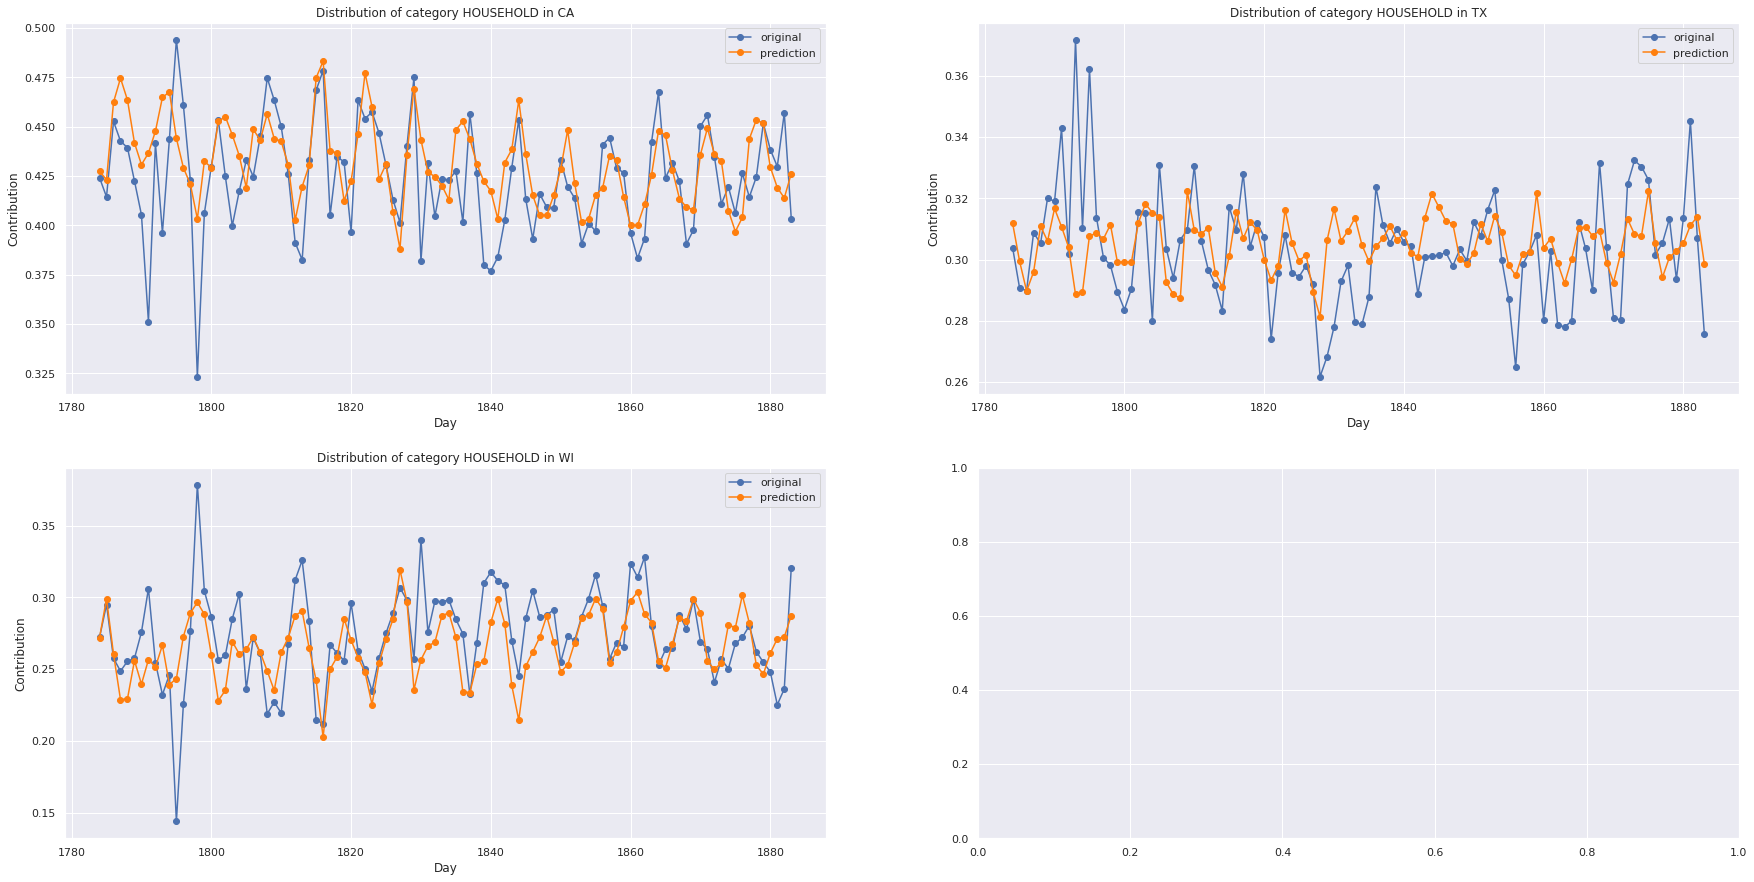

In [31]:
fig, axs = plt.subplots(2, 2, figsize=(30,15))

graph_start = 100
graph_end = 200

axs[0, 0].plot(testset_CA['t'][graph_start:graph_end], testset_CA['y1'][graph_start:graph_end], marker='o', label="original")
axs[0, 0].plot(testset_CA['t'][graph_start:graph_end], lr_pred_CA[:,0][graph_start:graph_end], 'tab:orange', marker='o', label="prediction")
axs[0, 0].set_title(f'Distribution of category {cat_id} in CA')
axs[0, 0].set(xlabel='Day', ylabel='Contribution')
axs[0, 0].legend(loc="upper right")

axs[0, 1].plot(testset_TX['t'][graph_start:graph_end], testset_TX['y2'][graph_start:graph_end], marker='o', label="original")
axs[0, 1].plot(testset_TX['t'][graph_start:graph_end], lr_pred_TX[:,0][graph_start:graph_end], 'tab:orange', marker='o', label="prediction")
axs[0, 1].set_title(f'Distribution of category {cat_id} in TX')
axs[0, 1].set(xlabel='Day', ylabel='Contribution')
axs[0, 1].legend(loc="upper right")

axs[1, 0].plot(testset_WI['t'][graph_start:graph_end], testset_WI['y3'][graph_start:graph_end], marker='o', label="original")
axs[1, 0].plot(testset_WI['t'][graph_start:graph_end], lr_pred_WI[:,0][graph_start:graph_end], 'tab:orange', marker='o', label="prediction")
axs[1, 0].set_title(f'Distribution of category {cat_id} in WI')
axs[1, 0].set(xlabel='Day', ylabel='Contribution')
axs[1, 0].legend(loc="upper right")


In [32]:
data

,id,item_id,dept_id,cat_id,store_id,state_id,d_1,d_2,d_3,d_4,d_5,d_6,d_7,d_8,d_9,d_10,d_11,d_12,d_13,d_14,d_15,d_16,d_17,d_18,d_19,d_20,d_21,d_22,d_23,d_24,d_25,d_26,d_27,d_28,d_29,d_30,d_31,d_32,d_33,d_34,...,d_1874,d_1875,d_1876,d_1877,d_1878,d_1879,d_1880,d_1881,d_1882,d_1883,d_1884,d_1885,d_1886,d_1887,d_1888,d_1889,d_1890,d_1891,d_1892,d_1893,d_1894,d_1895,d_1896,d_1897,d_1898,d_1899,d_1900,d_1901,d_1902,d_1903,d_1904,d_1905,d_1906,d_1907,d_1908,d_1909,d_1910,d_1911,d_1912,d_1913
0,HOBBIES_1_001_CA_1_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,1,1,3,1,3,1,2,2,0,1,1,1,1,0,0,0,0,0,1,0,4,2,3,0,1,2,0,0,0,1,1,3,0,1,1,1,3,0,1,1
1,HOBBIES_1_002_CA_1_validation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
2,HOBBIES_1_003_CA_1_validation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,2,2,1,2,1,1,1,0,1,1,1
3,HOBBIES_1_004_CA_1_validation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,1,3,4,2,1,4,1,3,5,0,6,6,0,0,0,0,3,1,2,1,3,1,0,2,5,4,2,0,3,0,1,0,5,4,1,0,1,3,7,2
4,HOBBIES_1_005_CA_1_validation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,1,0,3,2,2,2,3,1,0,0,0,0,1,0,4,4,0,1,4,0,1,0,1,0,1,1,2,0,1,1,2,1,1,0,1,1,2,2,2,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30485,FOODS_3_823_WI_3_validation,FOODS_3_823,FOODS_3,FOODS,WI_3,WI,0,0,2,2,0,3,1,4,1,0,0,3,4,4,0,0,1,0,1,1,7,7,3,6,3,3,7,12,4,2,7,5,12,5,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,2,0,0,0,0,0,1,0,0,1
30486,FOODS_3_824_WI_3_validation,FOODS_3_824,FOODS_3,FOODS,WI_3,WI,0,0,0,0,0,5,0,1,1,3,1,1,0,4,2,0,1,2,1,1,0,0,0,0,3,1,1,1,2,0,1,0,1,1,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,2,0,0,0,0,1,1,1,1,0,0,0,0,0,0,0,0,0,0,1,0
30487,FOODS_3_825_WI_3_validation,FOODS_3_825,FOODS_3,FOODS,WI_3,WI,0,6,0,2,2,4,1,8,5,2,7,5,3,5,20,8,10,3,3,4,7,2,3,5,6,3,4,1,2,5,1,2,2,2,...,1,1,2,0,0,2,0,0,0,2,0,1,1,0,0,0,0,1,1,2,1,4,0,0,2,2,4,0,0,0,2,1,0,2,0,1,0,0,1,0
30488,FOODS_3_826_WI_3_validation,FOODS_3_826,FOODS_3,FOODS,WI_3,WI,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,1,1,1,1,1,1,0,2,1,1,2,4,3,0,0,0,0,0,1,1,2,1,1,1,1,2,0,1,0,3,0,0,1,0,0,1,0,3,1,3


In [41]:
temp = np.sum(data[data['cat_id'] == 'HOBBIES'].iloc[:, 6:6+1913], axis=0)

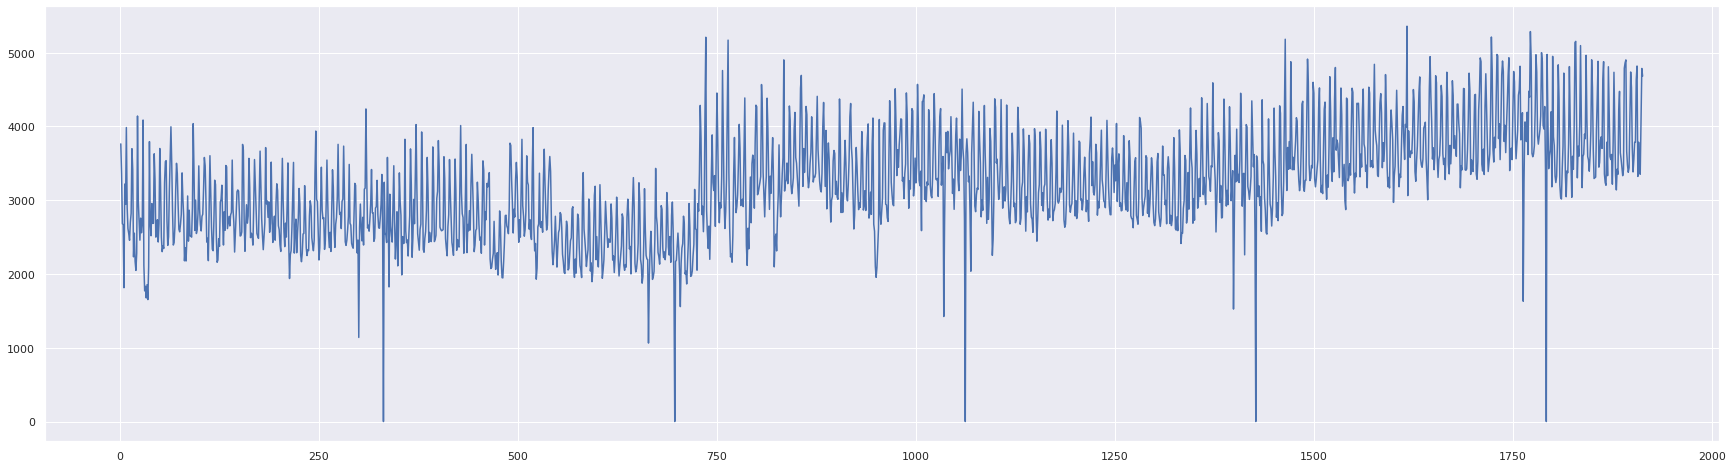

In [42]:
fig = plt.figure(figsize=(30,8))

plt.plot(range(1, 1914), temp)
# plt.figsize()
plt.show()